## **Importing Libraries**

In [ ]:
#  Call libraries
import numpy as np
import pandas as pd

# Import module imdb & other keras modules
import tensorflow as tf
from tensorflow.keras.datasets import imdb

# API to manipulate sequences of words
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential

# We will have three types of layers.
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Misc
import matplotlib.pyplot as plt
import time
import io

In [ ]:
import nltk

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
ps=PorterStemmer()

## **Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv("/gdrive/MyDrive/FA_Term_Project_NLP/Womens Clothing E-Commerce Reviews.csv")

## **Exploratory Data Analysis**

In [ ]:
# checking first 5 rows of the dataset
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
data.shape

(23486, 11)

In [ ]:
# Checking for null values
data.isnull().sum()

Unnamed: 0                 0
Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
text_length                0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [ ]:
(845/23846)*100

3.543571248846767

In [ ]:
def fill_missing(dataset):
    data["Title"].fillna(value="missing", inplace=True)
    data["Review Text"].fillna(value="missing", inplace=True)
    
    return (dataset)

In [ ]:
data = fill_missing(data)

In [ ]:
data['Division Name'] = data['Division Name'].fillna(data['Division Name'].mode()[0])
data['Department Name'] = data['Department Name'].fillna(data['Department Name'].mode()[0])
data['Class Name'] = data['Class Name'].fillna(data['Class Name'].mode()[0])

In [ ]:
data.isnull().sum()

Unnamed: 0                 0
Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

In [ ]:
data['Division Name'].mode()

0    General
dtype: object

In [ ]:
data['Division Name'].value_counts()

General           13864
General Petite     8120
Initmates          1502
Name: Division Name, dtype: int64

In [ ]:
# describtion of 5 numeric columns
describe=data.describe(include =['float', 'int'])
describe.T.style.background_gradient(low=0.2,high=0.5)

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,23486.000000,11742.500000,6779.968547,0.000000,5871.250000,11742.500000,17613.750000,23485.000000
Clothing ID,23486.000000,918.118709,203.298980,0.000000,861.000000,936.000000,1078.000000,1205.000000
Age,23486.000000,43.198544,12.279544,18.000000,34.000000,41.000000,52.000000,99.000000
Rating,23486.000000,4.196032,1.110031,1.000000,4.000000,5.000000,5.000000,5.000000
Recommended IND,23486.000000,0.822362,0.382216,0.000000,1.000000,1.000000,1.000000,1.000000
Positive Feedback Count,23486.000000,2.535936,5.702202,0.000000,0.000000,1.000000,3.000000,122.000000


In [ ]:
age = data.Age.value_counts().sort_index()
age_range = [10*i for i in range(1,10)]
store = []
age_data = pd.DataFrame(columns=['count','age'])
for idx,count in enumerate(age_range):
    store.append([age[num] for idx, num in enumerate(age.index) if num >=count and num<=count+9])
age = [str(num)+'to'+str(num+9) for num in age_range]
age_data['count'] = [sum(num) for num in store]
age_data['age'] = age

In [ ]:
import plotly.express as px
import plotly.figure_factory as ff

hist_data = [data['Age']]
group_labels = ['Age Distribution']

# 1. distribution plot
fig1 = ff.create_distplot(hist_data, group_labels, show_hist = False, colors=['#b2182b'])
fig1.update_layout(title = 'Age Distribution',template = "simple_white") 

# 2. bar plot
fig2 = px.bar(x = age_data['age'], 
              y = age_data['count'], 
              text = age_data['count'], color = age_data['age'],
              color_discrete_sequence = px.colors.sequential.RdBu,
              template = "simple_white",
              title = 'Age Bar Plot')
fig2.update_traces(width=0.7)

# marker line
idx = [num for num in range(2,5)]
for index in idx:
    fig2.data[index].marker.line.width = 2
    fig2.data[index].marker.line.color = "black"

fig1.update_layout(
    font=dict(size=15,family="Franklin Gothic"))
fig2.update_layout(
    xaxis_title="Age Range",
    yaxis_title="count",
    font=dict(size=15,family="Franklin Gothic"))

fig1.show()
fig2.show()

Age of customer mostly distributed in the range of 30 to 59

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


rating = data['Rating'].value_counts()
# 2 subplots
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

recommended = data['Recommended IND'].value_counts()
recommended = data['Recommended IND'].value_counts().sort_values(ascending=False)

# 1. Rating
fig.add_trace(go.Pie(values=rating.values,
             labels=rating.index, 
             marker=dict(colors=['#fddbc7','#f4a582','#d6604d','#b2182b','#67001f']),
             title= 'Rating',titlefont=dict(size=17)),row=1,col=1)
# 2. Recommended IND
fig.add_trace(go.Pie(values=recommended.values, 
             labels=recommended.index, 
             marker=dict(colors=['#fddbc7','#b2182b']),
             title= 'Recommended IND',titlefont=dict(size=17)),row=1,col=2)

fig.update_traces(textinfo='label+percent+value', textfont_size=14,
                  marker=dict(line=dict(color='black', width=0.2)))
fig.update_layout(
    font=dict(size=17,family="Franklin Gothic"))

1.Rating: Here, we can notice that 4 and 5 rates account about 77% of rating.

2.Recommended IND: About 82.2% products are recommended in the dataset.

In [ ]:
hist_data = [data['Positive Feedback Count']]
group_labels = ['Positive Feedback Count']

# 1. distribution plot
fig1 = ff.create_distplot(hist_data, group_labels,show_hist = False, colors = ['#b2182b'])
# 2. box plot
fig2 = px.box(data['Positive Feedback Count'],color_discrete_sequence=px.colors.sequential.RdBu,
              orientation='h')
fig1.update_layout(title = 'Positive Feedback Count Distribution',
                   font = dict(size=17, family = 'Franklin Gothic'),template = "simple_white") 
fig2.update_layout(title = 'Positive Feedback Count (Box Plot)',
                   font = dict(size=17, family = 'Franklin Gothic'),template = "simple_white")

fig1.show()
fig2.show()

"Positive Integer": documenting the number of other customers who found this review positive.

In [ ]:
import seaborn as sns
around_color = "#f6f5f5"
inside_color= "#f6f5f5"
colors = sns.color_palette("ch:s=-.2,r=.6")
colors


[(0.8892638312853967, 0.8490264305563623, 0.7570511784894085),
 (0.8312011153070852, 0.6672798070391869, 0.6068051318958765),
 (0.7437124386945118, 0.4851374768470097, 0.5389343244681717),
 (0.5896818664759845, 0.3380467461337321, 0.5001874678981432),
 (0.37244291281972614, 0.22471751711978527, 0.41709125523929924),
 (0.1544379249156812, 0.12779632898103252, 0.2480769565915658)]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



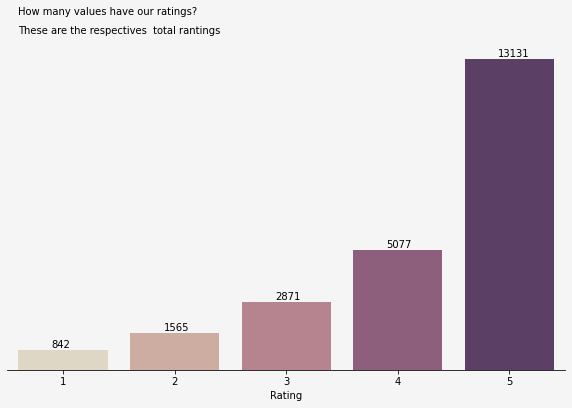

In [ ]:
fig = plt.figure(figsize=(10,6))
colors = colors
ax = plt.axes()
sns.countplot(data["Rating"], palette=colors);
fig.patch.set_facecolor(inside_color)
ax.set_facecolor(around_color)
plt.text(-0.4,15000, "How many values have our ratings?")
plt.text(-0.4,14200, "These are the respectives  total rantings " )
target = data["Rating"].value_counts()
values = target.values
index = target.index
for i,g in enumerate(values):
  o= [4,3,2,1,0]
  plt.text(o[i]-0.1,g+100, f"{g}")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()


56% customers have rated 5 rating wheras only 3.5% have rated 1

In [ ]:
!pip install transformers datasets

In [ ]:
from transformers import pipeline
from datasets import load_dataset
from datasets import Dataset

## **Sentiment Analysis using Hugging Face**

In [ ]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
data['Review Text'] = data['Review Text'].str.replace('"', '')
dataset_hf = Dataset.from_pandas(data)

In [ ]:
sentiments = classifier(dataset_hf['Review Text'])

In [ ]:
sentiments

[{'label': 'POSITIVE', 'score': 0.9998770952224731},
 {'label': 'POSITIVE', 'score': 0.9986211061477661},
 {'label': 'POSITIVE', 'score': 0.988560140132904},
 {'label': 'POSITIVE', 'score': 0.9998878240585327},
 {'label': 'POSITIVE', 'score': 0.9993934631347656},
 {'label': 'NEGATIVE', 'score': 0.8777441382408142},
 {'label': 'NEGATIVE', 'score': 0.6675721406936646},
 {'label': 'POSITIVE', 'score': 0.8755161166191101},
 {'label': 'POSITIVE', 'score': 0.9953872561454773},
 {'label': 'POSITIVE', 'score': 0.9974085688591003},
 {'label': 'NEGATIVE', 'score': 0.9996395111083984},
 {'label': 'POSITIVE', 'score': 0.9998140931129456},
 {'label': 'POSITIVE', 'score': 0.9985334873199463},
 {'label': 'POSITIVE', 'score': 0.9923502802848816},
 {'label': 'NEGATIVE', 'score': 0.991184413433075},
 {'label': 'POSITIVE', 'score': 0.9974316954612732},
 {'label': 'POSITIVE', 'score': 0.9995400905609131},
 {'label': 'POSITIVE', 'score': 0.9997902512550354},
 {'label': 'POSITIVE', 'score': 0.99952292442321

## **Question Answering**

In [ ]:
question_answerer = pipeline("question-answering")


No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
question_answerer(question="Which is most used cloth?",context = dataset_hf['Review Text'][0])

{'score': 0.5147171020507812,
 'start': 23,
 'end': 53,
 'answer': 'silky and sexy and comfortable'}

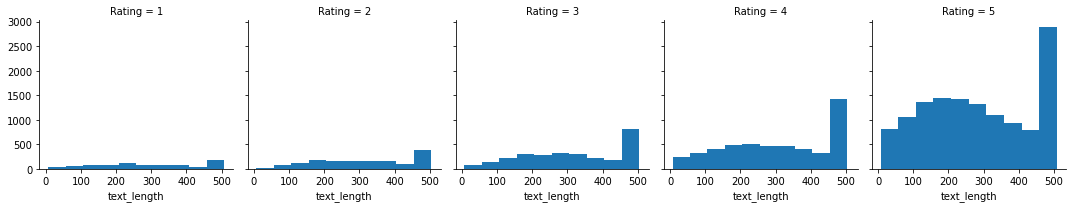

In [ ]:
data['text_length'] = data['Review Text'].str.len()
import seaborn as sns
g = sns.FacetGrid(data,col='Rating',palette='viridis')
g.map(plt.hist,'text_length')

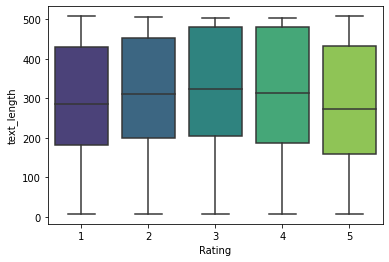

In [ ]:
sns.boxplot(x='Rating',y='text_length',data=data,palette='viridis')

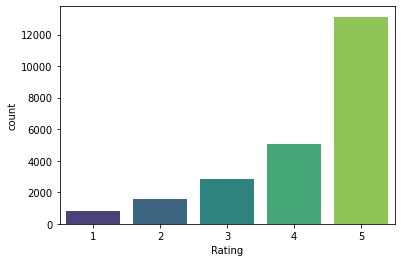

In [ ]:
sns.countplot(x='Rating',data=data,palette='viridis')

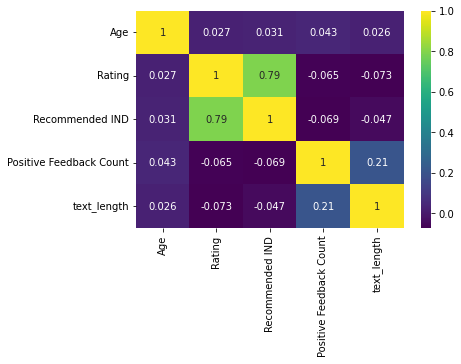

In [ ]:
sns.heatmap(data.drop(["Unnamed: 0","Clothing ID"], axis='columns').corr(),cmap='viridis',annot=True)

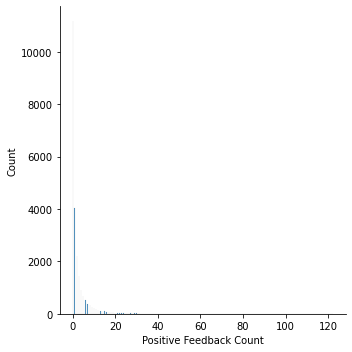

In [ ]:
sns.displot(data['Positive Feedback Count'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    23486 non-null  object
 4   Review Text              23486 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23486 non-null  object
 9   Department Name          23486 non-null  object
 10  Class Name               23486 non-null  object
 11  text_length              23486 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 2.2+ MB


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Text Pre-Processing**

In [ ]:
import re
corpus=[]
for i in range(len(data)):
  review=re.sub('[^a-zA-Z]',' ',data['Review Text'][i])
  review=review.lower()
  review=review.split()
  review=[ps.stem(i) for i in review if i not in set(stopwords.words('english'))]
  review=' '.join(review)
  corpus.append(review)

corpus 

['absolut wonder silki sexi comfort',
 'love dress sooo pretti happen find store glad bc never would order onlin bc petit bought petit love length hit littl knee would definit true midi someon truli petit',
 'high hope dress realli want work initi order petit small usual size found outrag small small fact could zip reorder petit medium ok overal top half comfort fit nice bottom half tight layer sever somewhat cheap net layer imo major design flaw net layer sewn directli zipper c',
 'love love love jumpsuit fun flirti fabul everi time wear get noth great compliment',
 'shirt flatter due adjust front tie perfect length wear leg sleeveless pair well cardigan love shirt',
 'love traci rees dress one petit feet tall usual wear p brand dress pretti packag lot dress skirt long full overwhelm small frame stranger alter shorten narrow skirt would take away embellish garment love color idea style work return dress',
 'ade basket hte last mintu see would look like person store pick went teh darkl

In [ ]:
len(corpus)

23486

In [ ]:
import wordcloud

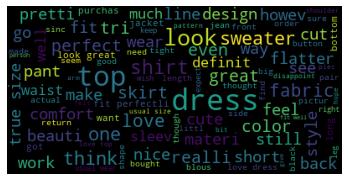

In [ ]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dense,LSTM,Embedding
from tensorflow.keras.models import Sequential

In [ ]:
vocab_size=10000
one_hot_repr=[one_hot(word,vocab_size) for word in corpus]
one_hot_repr[0]

[5013, 8474, 5885, 1899, 5347]

In [ ]:
sent_length=20
pad_doc=pad_sequences(one_hot_repr,padding='pre',maxlen=sent_length)
pad_doc[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 5013, 8474, 5885, 1899, 5347], dtype=int32)

In [ ]:
emb_vec_fea=100
model=Sequential()
model.add(Embedding(vocab_size,emb_vec_fea,input_length=sent_length))
model.add(LSTM(200))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           1000000   
                                                                 
 lstm (LSTM)                 (None, 200)               240800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 1,241,001
Trainable params: 1,241,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X=pad_doc
y=data['Recommended IND']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=100)

Epoch 1/10
188/188 [==============================] - 30s 144ms/step - loss: 0.3505 - accuracy: 0.8525 - val_loss: 0.2950 - val_accuracy: 0.8702
Epoch 2/10
188/188 [==============================] - 26s 138ms/step - loss: 0.2560 - accuracy: 0.8946 - val_loss: 0.3005 - val_accuracy: 0.8744
Epoch 3/10
188/188 [==============================] - 26s 140ms/step - loss: 0.2258 - accuracy: 0.9062 - val_loss: 0.3124 - val_accuracy: 0.8716
Epoch 4/10
188/188 [==============================] - 29s 152ms/step - loss: 0.2025 - accuracy: 0.9184 - val_loss: 0.3365 - val_accuracy: 0.8616
Epoch 5/10
188/188 [==============================] - 26s 139ms/step - loss: 0.1868 - accuracy: 0.9253 - val_loss: 0.3836 - val_accuracy: 0.8608
Epoch 6/10
188/188 [==============================] - 26s 138ms/step - loss: 0.1685 - accuracy: 0.9349 - val_loss: 0.3748 - val_accuracy: 0.8670
Epoch 7/10
188/188 [==============================] - 26s 139ms/step - loss: 0.1487 - accuracy: 0.9432 - val_loss: 0.4092 - val_ac

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred=model.predict(X_test)
y_pred=y_pred>0.5
print(classification_report(y_test,y_pred))

147/147 [==============================] - 4s 21ms/step
              precision    recall  f1-score   support

           0       0.58      0.55      0.57       851
           1       0.90      0.91      0.91      3847

    accuracy                           0.85      4698
   macro avg       0.74      0.73      0.74      4698
weighted avg       0.84      0.85      0.85      4698



## **Topic Modeling**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_top_n_words(n_top_word ,test_data):
    vectorizer = TfidfVectorizer(stop_words = 'english') #initialize the vectorizer to remove stop words
    transformed_vectorizer = vectorizer.fit_transform(test_data)
    print(vectorizer.get_feature_names())
    print('\n')
    print(transformed_vectorizer.toarray())

    vectorized_total = np.sum(transformed_vectorizer, axis = 0) # column wise addition
    print("Vectorized total is: ",vectorized_total)
  # print(np.argsort(vectorized_total))
  # print(np.argsort(vectorized_total)[0,:])
    print(np.flip(np.argsort(vectorized_total)[0,:]))
  # print(np.flip(np.argsort(vectorized_total)[0,:],1))
  # print(np.flip(np.sort(vectorized_total)[0,:],1))
    print(np.flip(np.sort(vectorized_total)[0,:]))
  # print(vectorized_total.shape[1]) # column
  # print(vectorized_total.shape)

    word_indices = np.flip(np.argsort(vectorized_total)[0,:],1)
    print("word index is : ",word_indices)
    word_value = np.flip(np.sort(vectorized_total)[0,:],1)
  # print("Word Value is = ",word_value)
    print("Word Value is = ",word_value[0,:n_top_word].tolist()[0])
  
  # create a 2d array with 15 row and column and fill them with zero

    word_vector = np.zeros((n_top_word,vectorized_total.shape[1]))

    for i in range(n_top_word):
    # print(i,word_indices[0,i])
        word_vector[i,word_indices[0,i]] = 1

  # print(word_vector)
  # print(vectorizer.inverse_transform(word_vector))

    inverse_vectorizer = vectorizer.inverse_transform(word_vector)
    print("inverse of vector is : ",inverse_vectorizer)
    words = [word[0] for word in inverse_vectorizer]
    print(words)
    return(words, word_value[0,:n_top_word].tolist()[0])

In [ ]:
# get the top n words from the text by converting them into vector
'''
function gets a tuple of top n words and their count.
'''
# get_top_n_words(n_top_word = 15,test_data = test_text)
words, words_val = get_top_n_words(n_top_word = 15,test_data = data["Review Text"].values)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['00', '000', '00p', '02', '03', '03dd', '04', '06', '0dd', '0in', '0p', '0petite', '0r', '0verall', '0xs', '10', '100', '1000', '100lb', '100lbs', '101', '102', '102lbs', '103', '103lb', '103lbs', '104', '104lbs', '105', '105lb', '105lbs', '106', '106lbs', '107', '107lb', '107lbs', '107pound', '108', '108lbs', '109', '109lbs', '10l', '10lbs', '10mths', '10p', '10s', '10th', '10x', '11', '110', '110lb', '110lbs', '111', '111lbs', '112', '112lb', '112lbs', '112llbs', '113', '1130', '113lbs', '114', '114lb', '114lbs', '115', '115ish', '115lb', '115lbs', '115llbs', '116', '116bs', '116ibs', '116lb', '116lbs', '117', '117bl', '117lbs', '118', '118lb', '118lbs', '119', '11and', '11in', '11inches', '12', '120', '120lb', '120lbs', '121', '122', '122lb', '122lbs', '123', '123lb', '123lbs', '123lbssize', '124', '124lb', '124lbs', '125', '125b', '125ibs', '125ish', '125lb', '125lbs', '126', '126lbs', '127', '127lb', '127lbs', '128', '128b', '128lb', '128lbs', '129', '129lbs', '12p', '12th', '13'

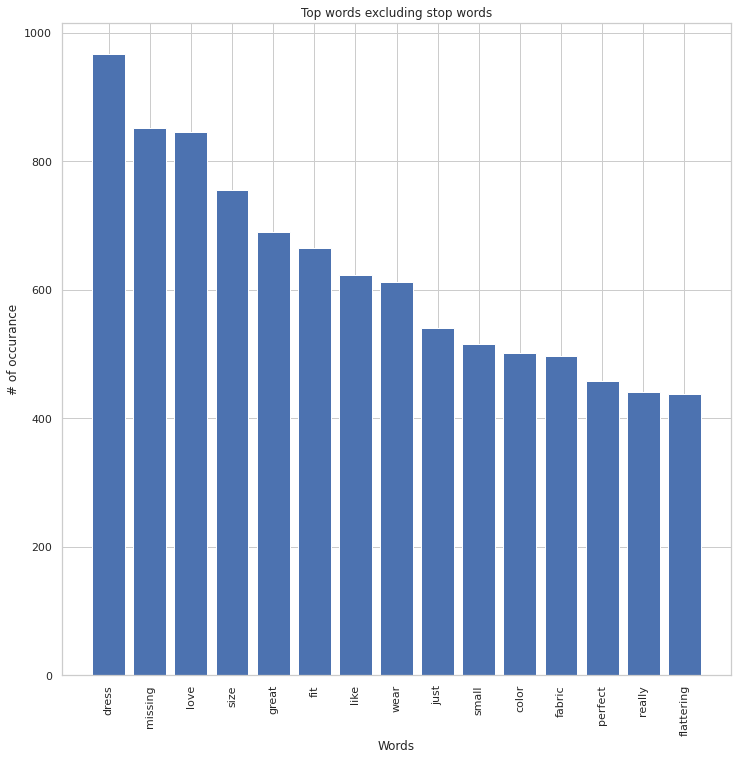

In [ ]:
sns.set_theme(style="whitegrid")
fig,ax = plt.subplots(figsize=(12,12)) # this is needed when you are using axis.bar
ax.bar(words,words_val) 
ax.set_xticklabels(words, rotation='vertical') # makes the word vertical
plt.title('Top words excluding stop words',fontsize = 12)
plt.ylabel('# of occurance',fontsize = 12)
plt.xlabel('Words',fontsize=12)
plt.show()

Out of Top 15 Words, love is one of them which shows that they have a lot of happy customers who are fond of dress